In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier,Pool
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import warnings
import time
import glob
import sys
import os
import gc

In [5]:
# for get better result chage fold_n to 5
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

In [6]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [7]:
# посмотрим на заголовок обучающей выборки
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.093000000000000,11.460699999999999,-9.2834,5.1187,18.626600000000000,-4.9200,5.747000000000001,2.9252,3.182100000000000,14.013700000000000,0.574500000000000,8.7989,14.569100000000001,5.748700000000000,-7.239300000000000,4.284000000000000,30.713300000000000,10.535000000000000,16.219100000000001,2.579100000000000,2.4716,14.383100000000001,13.432499999999999,-5.1488,-0.4073,4.9306,5.9965,-0.308500000000000,12.904100000000000,-3.8766,16.891100000000002,11.192000000000000,10.5785,0.6764,7.8871,...,15.457599999999999,5.3133,3.6159,5.038400000000000,6.676000000000000,12.664400000000001,2.7004,-0.6975,9.598100000000001,5.4879,-4.7645,-8.4254,20.877300000000002,3.1531,18.561800000000002,7.742300000000000,-10.124499999999999,13.724100000000000,-3.518900000000000,1.720200000000000,-8.405099999999999,9.016400000000001,3.065700000000000,14.369100000000000,25.839800000000000,5.8764,11.841100000000001,-19.715900000000001,17.574300000000001,0.5857,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.388999999999999,12.362200000000000,7.0433,5.6208,16.533799999999999,3.1468,8.085100000000001,-0.4032,8.058500000000000,14.023899999999999,8.413500000000001,5.4345,13.700300000000000,13.827500000000001,-15.584899999999999,7.800000000000000,28.570799999999998,3.428700000000000,2.740700000000000,8.552400000000000,3.3716,6.977900000000000,13.890999999999998,-11.7684,-2.5586,5.0464,0.5481,-9.298700000000000,7.875500000000000,1.2859,19.370999999999999,11.370200000000001,0.7399,2.7995,5.8434,...,29.484600000000000,5.8683,3.8208,15.834800000000000,-5.012100000000000,15.134499999999999,3.2003,9.3192,3.882100000000000,5.7999,5.5378,5.0988,22.033000000000001,5.5134,30.264500000000002,10.496800000000000,-7.235200000000000,16.572099999999999,-7.347700000000000,11.075200000000001,-5.593700000000000,9.487800000000000,-14.910000000000000,9.424500000000000,22.544100000000000,-4.8622,7.654300000000000,-15.931900000000001,13.317500000000001,-0.3566,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.355999999999998,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.892800000000000,10.582500000000000,-9.0837,6.9427,14.615500000000001,-4.9193,5.952500000000000,-0.3249,-11.264799999999999,14.192900000000000,7.312400000000000,7.5244,14.647200000000000,7.678200000000000,-1.739500000000000,4.701100000000000,20.477499999999999,17.755900000000000,18.137699999999999,1.214500000000000,3.5137,5.677700000000000,13.217700000000001,-7.9940,-2.9029,5.8463,6.1439,-11.102499999999999,12.485799999999999,-2.2871,19.042200000000001,11.044900000000000,4.1087,4.6974,6.9346,...,13.207000000000001,5.8442,4.7086,5.714100000000000,-1.041000000000000,20.509200000000000,3.2790,-5.5952,7.317600000000000,5.7690,-7.0927,-3.9116,7.256900000000000,-5.8234,25.681999999999999,10.920199999999999,-0.310400000000000,8.843800000000000,-9.700900000000001,2.401300000000000,-4.293500000000000,9.390800000000000,-13.264799999999999,3.154500000000000,23.086600000000001,-5.3000,5.374500000000000,-6.266000000000000,10.193400000000000,-0.8417,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,

In [8]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.953600000000000,9.4292,11.432700000000001,-2.380500000000000,5.8493,18.267499999999998,2.1337,8.810000000000000,-2.0248,-4.3554,13.9696,0.345800000000000,7.5408,14.500100000000000,7.702800000000000,-19.091899999999999,15.580600000000000,16.176300000000001,3.7088,18.806400000000000,1.5899,3.0654,6.450900000000000,14.119199999999999,-9.4902,-2.1917,5.710700000000000,3.7864,-1.798100000000000,9.264500000000000,2.0657,12.775300000000000,11.333399999999999,8.1462,-0.0610,3.5331,9.780400000000000,...,5.923200000000000,5.4113,3.8302,5.738000000000000,-8.610500000000000,22.953000000000003,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.084900000000001,8.468500000000001,18.131699999999999,12.281800000000000,-0.691200000000000,10.222600000000000,-5.5579,2.2926,-4.5358,10.390300000000000,-15.4937,3.9697,31.352100000000000,-1.1651,9.2874,-23.570499999999999,13.264300000000000,1.6591,-2.1556,11.849500000000001,-1.4300,2.4508,13.711200000000000,2.4669,4.3654,10.720000000000001,15.472200000000001,-8.719700000000000
1,test_1,8.5304,1.2543,11.304700000000000,5.1858,9.197400000000000,-4.011700000000000,6.0196,18.631599999999999,-4.4131,5.973900000000000,-1.3809,-0.3310,14.1129,2.566700000000000,5.4988,14.185300000000000,7.019600000000000,4.656400000000000,29.160900000000002,0.091000000000000,12.1469,3.138900000000000,5.2578,2.4228,16.206399999999999,13.502300000000000,-5.2341,-3.6648,5.707999999999999,2.9965,-10.472000000000001,11.493800000000000,-0.9660,15.344500000000000,10.636100000000001,0.8966,6.7428,2.3421,12.867800000000001,...,30.964099999999998,5.6723,3.6873,13.042899999999999,-10.657200000000000,15.513400000000001,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.922699999999999,-5.627400000000000,10.501799999999999,9.608300000000000,-0.493500000000000,8.169600000000001,-4.3605,5.2110,0.4087,12.003000000000000,-10.3812,5.8496,25.195799999999998,-8.8468,11.8263,-8.711200000000000,15.907200000000000,0.9812,10.6165,8.834899999999999,0.9403,10.1282,15.576499999999999,0.4773,-1.4852,9.871400000000000,19.129300000000001,-20.975999999999999
2,test_2,5.4827,-10.3581,10.140700000000001,7.0479,10.262800000000000,9.805199999999999,4.8950,20.253699999999998,1.5233,8.344200000000001,-4.7057,-3.0422,13.6751,3.818300000000000,10.8535,14.212600000000000,9.883699999999999,2.654100000000000,21.218100000000000,20.816299999999998,12.4666,12.369600000000000,4.7473,2.7936,5.218900000000000,13.567000000000000,-15.4246,-0.1655,7.263300000000000,3.4310,-9.150800000000000,9.732000000000001,3.1062,22.307600000000001,11.959300000000001,9.9255,4.0702,4.9934,8.066700000000001,...,39.365400000000001,5.5228,3.3159,4.332400000000000,-0.538200000000000,13.300900000000000,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.887400000000000,-2.978700000000000,27.403500000000001,15.881900000000000,-10.965999999999999,15.641500000000001,-9.4056,4.4611,-3.0835,8.554900000000000,-2.8517,13.4770,24.472100000000001,-3.4824,4.9178,-2.072000000000000,11.539000000000001,1.1821,-0.7484,10.993499999999999,1.9803,2.1800,12.981299999999999,2.1281,-7.1086,7.061800000000000,19.895600000000002,-23.179400000000001
3,test_3,8.5374,-1.3222,12.022000000000000,6.5749,8.845800000000001,3.174400000000000,4.9397,20.565999999999999,3.3755,7.457800000000000,0.0095,-5.0659,14.0526,13.500999999999999,8.7660,14.735200000000001,10.038300000000000,-15.350800000000000,2.127300000000000,21.479700000000

In [9]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [10]:
sample_submission.shape

(200000, 2)

In [11]:
train_df.shape, test_df.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [12]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
#снижение объёма памяти
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [13]:
#Reducing for train data set
train, NAlist = reduce_mem_usage(train_df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276153564453  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_66
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_67
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_136
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_143
dtype before:  float64
dtype af

In [14]:
#Reducing for test data set
test, NAlist = reduce_mem_usage(test_df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017364501953  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

dtype after:  float32
******************************
******************************
Column:  var_67
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_134
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_135
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_136
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype af

In [15]:
#Data set fields
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [16]:
print(len(train.columns))

202


In [17]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
None


In [18]:
#numerical values Describe
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,7.567198753356934,0.394344419240952,-3.245583534240723,14.023975372314453,8.530260086059570,7.537585735321045,14.573036193847656,9.333322525024414,-5.696696281433105,15.244025230407715,12.438426017761230,13.290937423706055,17.257947921752930,4.305424690246582,3.019564151763916,10.584388732910156,13.667485237121582,-4.055144309997559,-1.137891292572021,5.532967090606689,5.053869247436523,-7.687808036804199,10.393088340759277,-0.512887895107269,14.774120330810547,11.434164047241211,3.842468976974487,2.187225580215454,5.868919372558594,10.642142295837402,...,24.259389877319336,5.633270740509033,5.362925052642822,11.002311706542969,-2.871894598007202,19.315820693969727,2.963322877883911,-4.151159763336182,4.937124252319336,5.636033535003662,-0.004962081089616,-0.831779837608337,19.817010879516602,-0.677969634532928,20.210577011108398,11.640645027160645,-2.799602746963501,11.882902145385742,-1.014055371284485,2.591427803039551,-2.741673231124878,10.085389137268066,0.719106554985046,8.769108772277832,12.756799697875977,-3.983258008956909,8.970232009887695,-10.334982872009277,15.377336502075195,0.746070563793182,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789

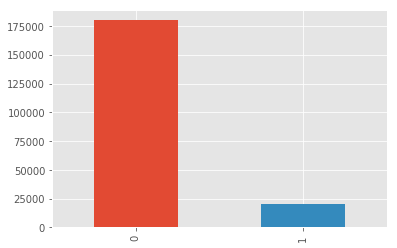

In [19]:
#Visualization
##hist
train['target'].value_counts().plot.bar();

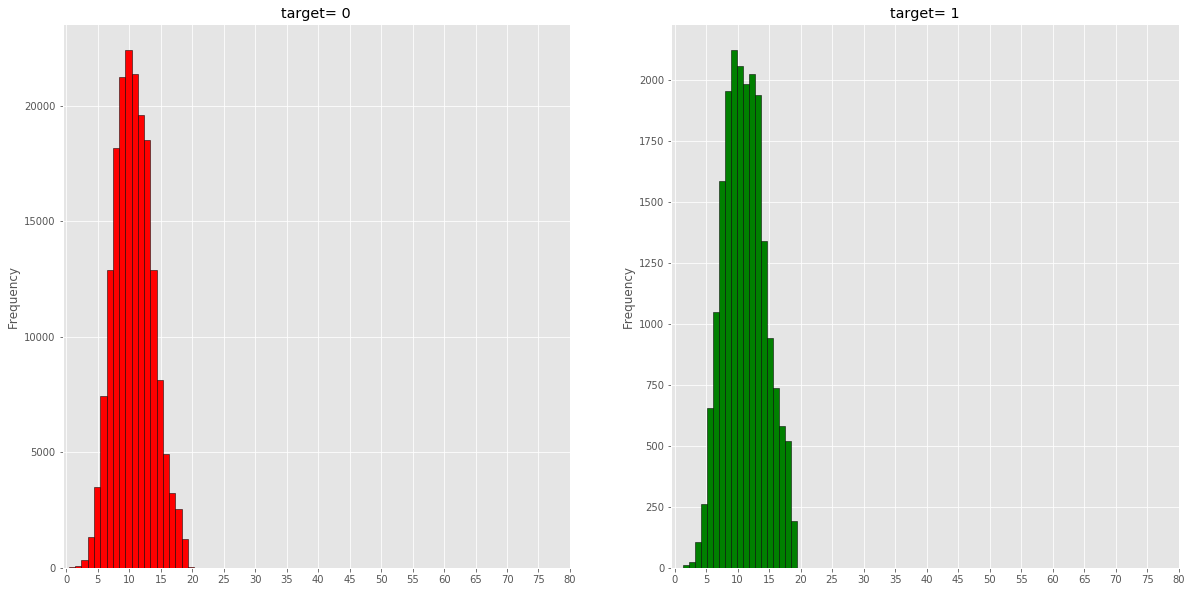

In [20]:
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

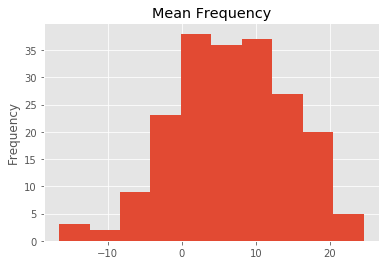

In [21]:
##Mean Frequency
train[train.columns[2:]].mean().plot('hist');plt.title('Mean Frequency');

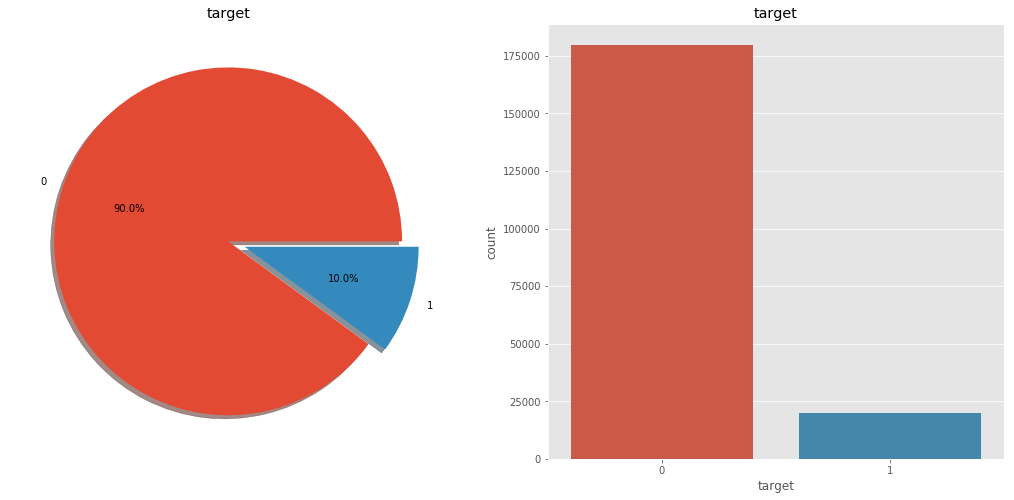

In [22]:
##countplot
f,ax=plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=train,ax=ax[1])
ax[1].set_title('target')
plt.show()

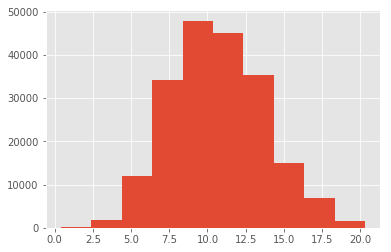

In [23]:
##hist If you check histogram for all feature, you will find that most of them are so similar
train["var_0"].hist();

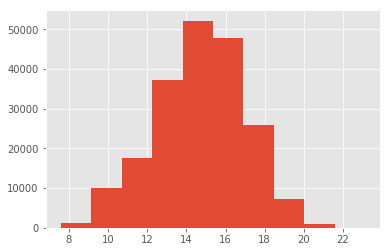

In [24]:
train["var_81"].hist();

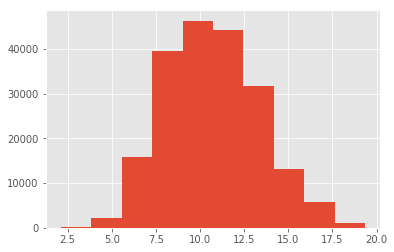

In [25]:
train["var_2"].hist();

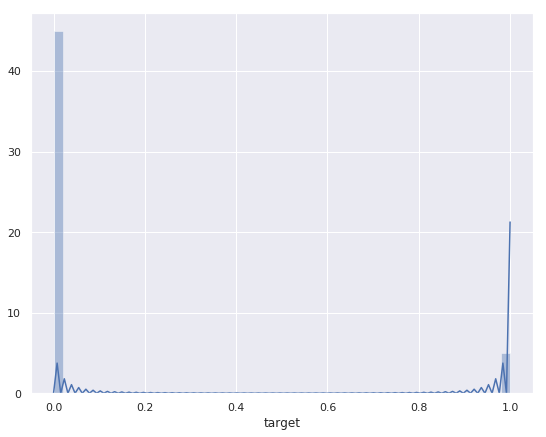

In [26]:
##distplot The target in data set is imbalance
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);

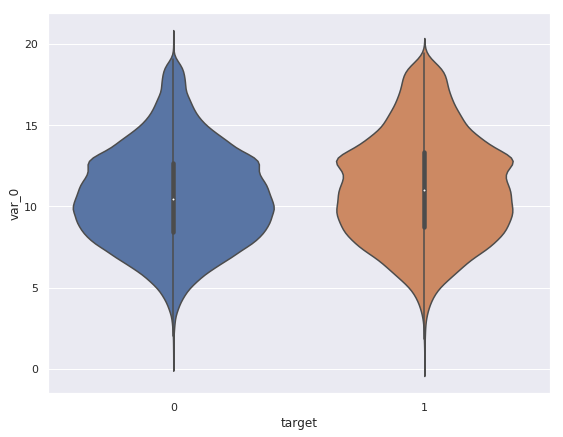

In [27]:
##violinplot
sns.violinplot(data=train,x="target", y="var_0")

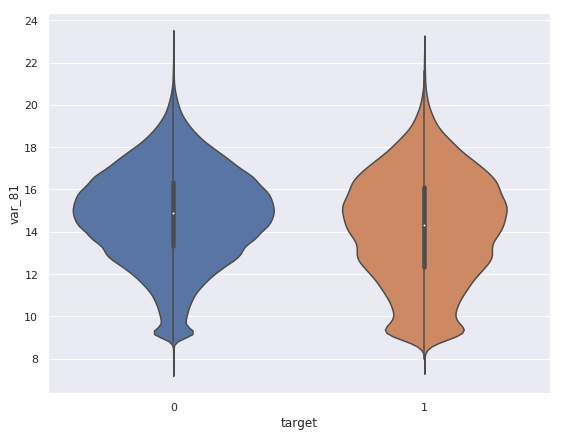

In [28]:
sns.violinplot(data=train,x="target", y="var_81")

In [29]:
#Data Preprocessing

In [30]:
#Check missing data for test & train
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        # written by MJ Bahmani
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [31]:
check_missing_data(train)

False

In [32]:
check_missing_data(test)

False

In [33]:
#Binary Classification
train['target'].unique()

array([0, 1], dtype=uint64)

In [34]:
#Is data set imbalance?
#A large part of the data is unbalanced, but how can we solve it?
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [35]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')

In [36]:
check_balance(train,'target')

size of data is: 200000
for target  0 =
89.95100000000001 %
for target  1 =
10.049 %


In [37]:
#skewness and kurtosis или ассиметрия и куртосис
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


In [38]:
#Permutation Importance
##Prepare our data for our model
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]

In [39]:
X_test  = test.drop("ID_code",axis=1)

In [40]:
##Create a sample model to calculate which feature are more important.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [41]:
#How to calculate and show importances?
##ELI5 is a Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models.
##Here is how to calculate and show importances with the eli5 library:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [42]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


In [43]:
#Partial Dependence Plots
##partial dependence plots show how a feature affects predictions. And partial dependence plots are calculated after a model has been fit.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [44]:
#For the sake of explanation, I use a Decision Tree which you can see below.
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [45]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

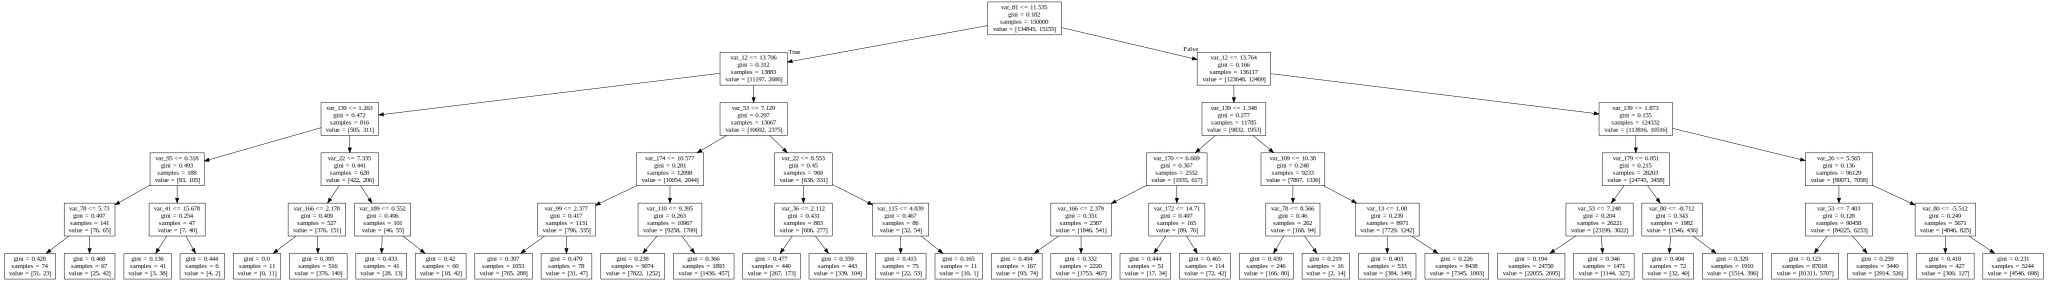

In [46]:
graphviz.Source(tree_graph)

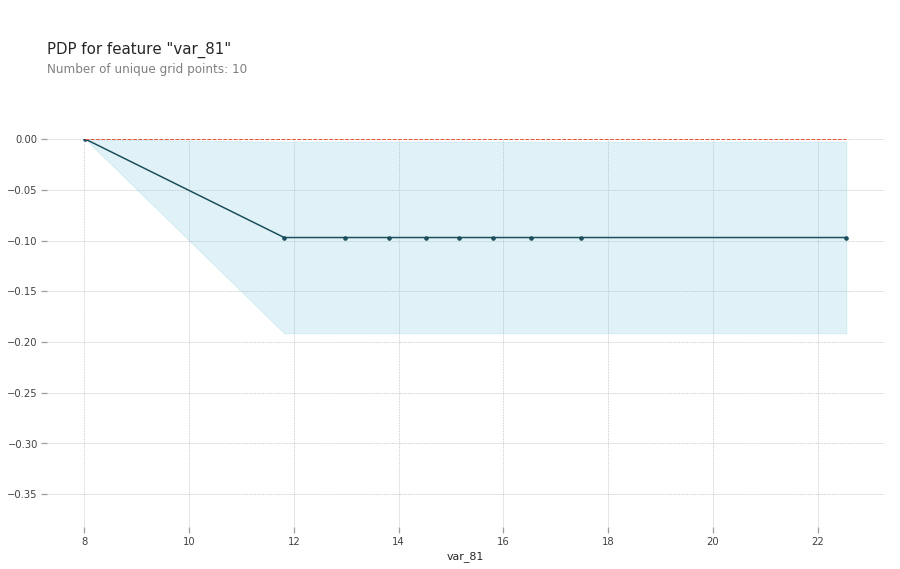

In [47]:
#Partial Dependence Plot
##In this section, we see the impact of the main variables discovered in the previous sections by using the pdpbox.
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

In [48]:
#Chart analysis
  ##The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
  ##A blue shaded area indicates level of confidence

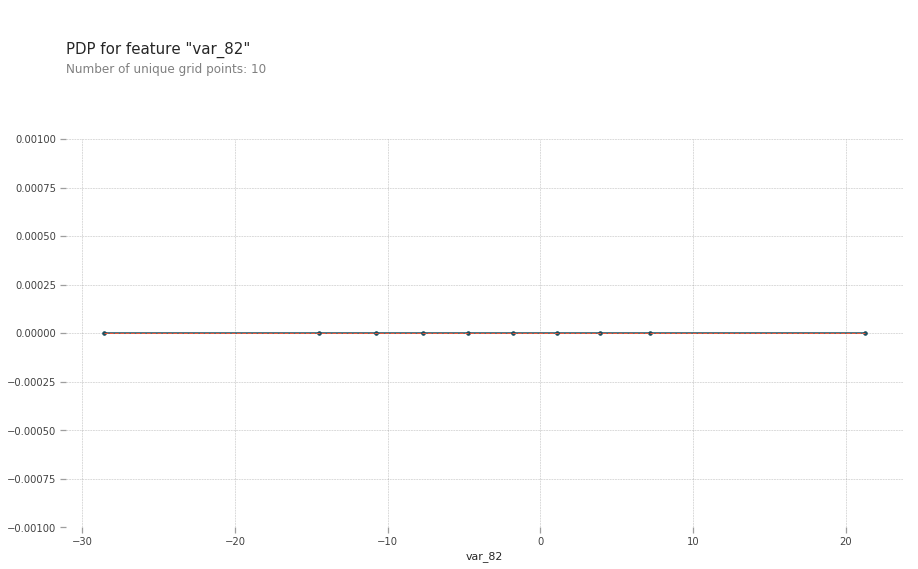

In [49]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_82')

# plot it
pdp.pdp_plot(pdp_goals, 'var_82')
plt.show()

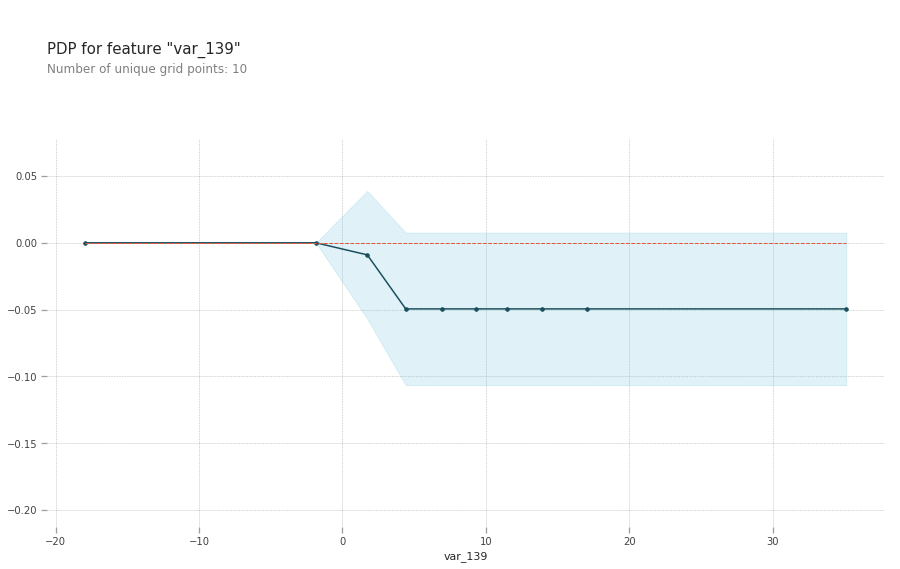

In [50]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

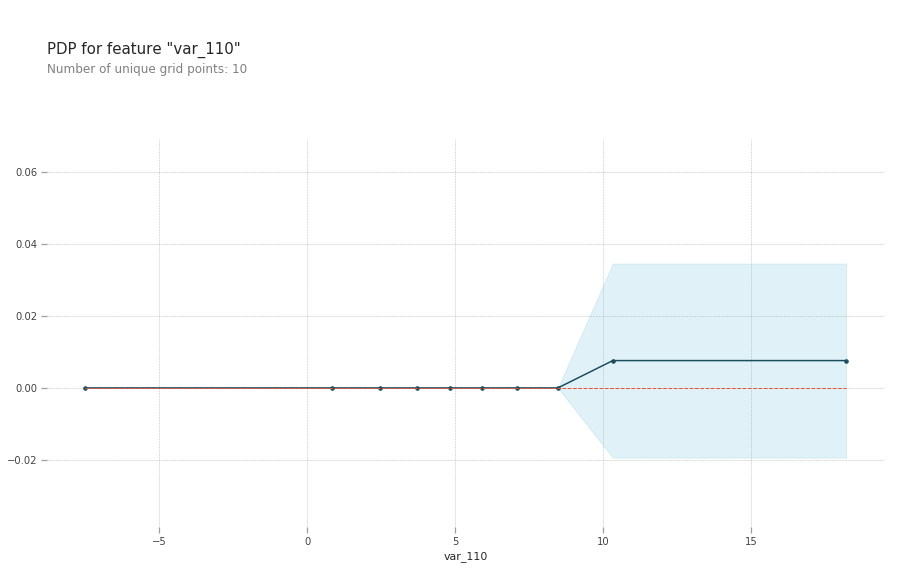

In [51]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

In [52]:
#SHAP Value
##SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see the SHAP NIPS paper for details).
##Shap can answer to this qeustion : how the model works for an individual prediction?
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


rfc_model.predict_proba(data_for_prediction_array);

In [53]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [55]:
#Model Development
##lightgbm
# params is based on following kernel https://www.kaggle.com/brandenkmurray/nothing-works
params = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [56]:
%%time
y_pred_lgb = np.zeros(len(X_test))
num_round = 1000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_round,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3500)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Fri Apr  5 13:02:57 2019
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.901253	valid_1's auc: 0.878517
[2000]	training's auc: 0.913832	valid_1's auc: 0.887269
[3000]	training's auc: 0.921987	valid_1's auc: 0.891626
[4000]	training's auc: 0.928122	valid_1's auc: 0.894103
[5000]	training's auc: 0.933228	valid_1's auc: 0.89534
[6000]	training's auc: 0.937804	valid_1's auc: 0.89587
[7000]	training's auc: 0.941946	valid_1's auc: 0.896424
[8000]	training's auc: 0.945795	valid_1's auc: 0.896424
[9000]	training's auc: 0.949434	valid_1's auc: 0.896426
[10000]	training's auc: 0.952996	valid_1's auc: 0.896493
[11000]	training's auc: 0.956271	valid_1's auc: 0.896529
[12000]	training's auc: 0.959457	valid_1's auc: 0.896511
[13000]	training's auc: 0.962405	valid_1's auc: 0.896332
[14000]	training's auc: 0.965332	valid_1's auc: 0.896246
Early stopping, best iteration is:
[11318]	training's auc: 0.957332	valid_1's auc: 0.896572
Fold 1 started

In [57]:
##RandomForestClassifier
y_pred_rfc = rfc_model.predict(X_test)

In [58]:
##DecisionTreeClassifier
y_pred_tree = tree_model.predict(X_test)

In [59]:
##CatBoostClassifier
train_pool = Pool(train_X,train_y)
cat_model = CatBoostClassifier(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               objective="Logloss",
                               eval_metric='AUC',
                              )
cat_model.fit(train_X,train_y,silent=True)
y_pred_cat = cat_model.predict(X_test)

In [60]:
submission_rfc = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_rfc
    })
submission_rfc.to_csv('submission_rfc.csv', index=False)

In [61]:
submission_tree = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_tree
    })
submission_tree.to_csv('submission_tree.csv', index=False)

In [62]:
submission_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_cat
    })
submission_cat.to_csv('submission_cat.csv', index=False)

In [63]:
# good for submit
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)

In [64]:
#Funny Combine
submission_rfc_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_cat)/2
    })
submission_rfc_cat.to_csv('submission_rfc_cat.csv', index=False)

In [65]:
submission_lgb_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_lgb +y_pred_cat)/2
    })
submission_lgb_cat.to_csv('submission_lgb_cat.csv', index=False)

In [66]:
submission_rfc_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_lgb)/2
    })
submission_rfc_lgb.to_csv('submission_rfc_lgb.csv', index=False)